In [46]:
import numpy as np
import pandas as pd
import torch
import sklearn
from sklearn.model_selection import cross_val_score, train_test_split
from torch import Tensor, nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import colors
from xgboost import XGBClassifier


In [47]:
data = pd.read_csv('./../input/data.csv')
data

,student,exam 1,exam 2,exam 3,final,pass,personality 0,personality 1,personality 2,personality 3,personality 4,personality 5
0,1,3.276017,4.844990,3.674589,3.513488,0,1,0,0,0,0,0
1,2,3.189663,3.742028,3.955839,3.304861,0,1,0,0,0,0,0
2,3,3.946272,2.744362,2.294078,2.890133,0,1,0,0,0,0,0
3,4,4.645853,3.585932,3.748032,4.363275,1,1,0,0,0,0,0
4,5,2.924525,3.655331,3.370484,3.322329,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
700,701,4.809057,5.358747,4.614448,5.122788,1,0,0,0,0,0,1
701,702,5.480948,5.248335,5.692704,5.643223,1,0,0,0,0,0,1
702,703,5.447278,4.295340,5.457058,5.391904,1,0,0,0,0,0,1
703,704,4.594921,4.462136,5.518867,4.666433,1,0,0,0,0,0,1


Text(0.5, 0, 'Exam 3')

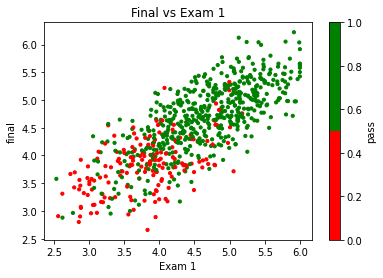

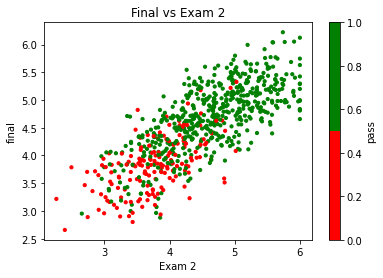

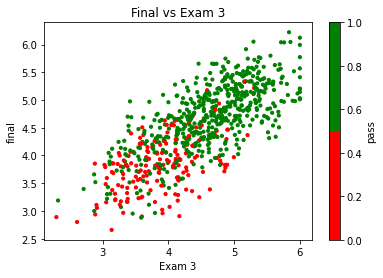

In [48]:
data.plot.scatter(x="exam 1", y="final", c="pass", s=10, cmap=colors.ListedColormap(['red', 'green']), sharex=False)
plt.title("Final vs Exam 1")
plt.xlabel("Exam 1")

data.plot.scatter(x="exam 2", y="final", c="pass", s=10, cmap=colors.ListedColormap(['red', 'green']), sharex=False)
plt.title("Final vs Exam 2")
plt.xlabel("Exam 2")

data.plot.scatter(x="exam 3", y="final", c="pass", s=10, cmap=colors.ListedColormap(['red', 'green']), sharex=False)
plt.title("Final vs Exam 3")
plt.xlabel("Exam 3")




In [49]:

train_df, test_df = train_test_split(data, test_size=0.75)


# Data Preparation

In [50]:
def prepare_data(data: pd.DataFrame) -> (np.ndarray, np.ndarray, np.ndarray, int, int):
    x_orig = data[["exam 1", "exam 2", "exam 3", "personality 0", "personality 1", "personality 2", "personality 3", "personality 4", "personality 5"]].to_numpy()
    dim = x_orig.shape[1]
    data_size = x_orig.shape[0]

    x = x_orig.T
    y = data["pass"].to_numpy().reshape((1, data_size))

    return x_orig, x, y, dim, data_size

# train_x_orig = train_df[["exam 1", "exam 2", "exam 3", "personality 0", "personality 1", "personality 2", "personality 3", "personality 4", "personality 5"]].to_numpy()
# dim = train_x_orig.shape[1]
# train_size = train_x_orig.shape[0]
#
#
# train_x = train_x_orig.T
# train_y = train_df["pass"].to_numpy().reshape((1, train_size))


train_x_orig, train_X, train_y, dim, train_size = prepare_data(train_df)
dev_X_orig, dev_X, dev_y, _, dev_size = prepare_data(dev_df)
test_X_orig, test_X, test_y, _, test_size = prepare_data(test_df)

train_X_tensor = torch.tensor(train_X, dtype=torch.float)
train_y_tensor = torch.tensor(train_y, dtype=torch.float)

dev_X_tensor = torch.tensor(dev_X, dtype=torch.float)
dev_y_tensor = torch.tensor(dev_y, dtype=torch.float)

test_X_tensor = torch.tensor(test_X, dtype=torch.float)
test_y_tensor = torch.tensor(test_y, dtype=torch.float)

assert train_X.shape == (dim, train_size)
assert train_y.shape == (1, train_size)
assert dev_X.shape == (dim, dev_size)
assert dev_y.shape == (1, dev_size)
assert test_X.shape == (dim, test_size)
assert test_y.shape == (1, test_size)


# Logistic regression


In [51]:
def initialize(dim):
    W = torch.tensor(np.random.randn(1, dim), dtype=torch.float, requires_grad=True)
    b = torch.tensor(np.random.randn(1,1), dtype=torch.float, requires_grad=True)
    return W, b

def forward(X: Tensor, W: Tensor, b: Tensor) -> Tensor:
    return W.matmul(X) + b

def sigmoid_activation(Z: Tensor) -> Tensor:
    return torch.sigmoid(Z)

def evaluate_f1(pred_y, y) -> float:
    """
    Print the evaluation metric.
    :param pred_y: Input
    :param y: Expected output
    """
    pred_y_classes = pred_y

    if isinstance(pred_y_classes, torch.Tensor):
        pred_y_classes = pred_y_classes.detach().numpy().flatten()

    pred_y_classes[pred_y_classes >= 0.5] = 1
    pred_y_classes[pred_y_classes < 0.5] = 0
    return sklearn.metrics.f1_score(y_true=y.flatten(), y_pred=pred_y_classes)


class LogRegModel:
    def __init__(self, W, b):
        self.W = W
        self.b = b

    def predict(self, X) -> Tensor:
        if not isinstance(X, Tensor):
            X = torch.tensor(X, dtype=torch.float)

        Z = forward(X, self.W, self.b)
        return sigmoid_activation(Z)

### Training

In [58]:
def learn_logreg(train_x, train_y) -> LogRegModel:
    print("Learning")

    W, b = initialize(train_x.shape[0])
    assert W.shape == (1, train_x.shape[0])

    model = LogRegModel(W, b)
    optimizer = torch.optim.SGD([W, b], lr=0.001)

    for i in range(0,10000):
        pred_y = model.predict(train_x)

        optimizer.zero_grad()
        loss = F.binary_cross_entropy(pred_y, train_y)

        if i < 20 or i % 50 == 0:
            print(f'{i}) Loss: {loss} \t| F1: {evaluate_f1(pred_y, train_y)}')

        loss.backward()
        optimizer.step()

    return LogRegModel(W, b)

train_X_tensor = torch.tensor(train_X, dtype=torch.float)
train_y_tensor = torch.tensor(train_y, dtype=torch.float)

logreg_model: LogRegModel = learn_logreg(train_X_tensor, train_y_tensor)

Learning
0) Loss: 1.478105902671814 	| F1: 0.16666666666666666
1) Loss: 1.4611796140670776 	| F1: 0.178343949044586
2) Loss: 1.4445661306381226 	| F1: 0.178343949044586
3) Loss: 1.4282639026641846 	| F1: 0.178343949044586
4) Loss: 1.4122697114944458 	| F1: 0.2125
5) Loss: 1.396581768989563 	| F1: 0.2111801242236025
6) Loss: 1.3811970949172974 	| F1: 0.22085889570552147
7) Loss: 1.3661128282546997 	| F1: 0.22085889570552147
8) Loss: 1.3513258695602417 	| F1: 0.22085889570552147
9) Loss: 1.3368330001831055 	| F1: 0.21951219512195122
10) Loss: 1.3226313591003418 	| F1: 0.22891566265060243
11) Loss: 1.308717966079712 	| F1: 0.22891566265060243
12) Loss: 1.2950886487960815 	| F1: 0.2395209580838323
13) Loss: 1.2817401885986328 	| F1: 0.2485207100591716
14) Loss: 1.2686688899993896 	| F1: 0.25882352941176473
15) Loss: 1.2558709383010864 	| F1: 0.25882352941176473
16) Loss: 1.2433433532714844 	| F1: 0.26744186046511625
17) Loss: 1.231081485748291 	| F1: 0.29714285714285715
18) Loss: 1.2190819

### Evaluate

In [53]:
logreg_train_f1 = evaluate_f1(logreg_model.predict(train_X), train_y)
logreg_dev_f1 = evaluate_f1(logreg_model.predict(dev_X), dev_y)

print(f'DNN: Train F1: {logreg_train_f1}')
print(f'DNN: Dev F1: {logreg_dev_f1}')


DNN: Train F1: 0.8791946308724833
DNN: Dev F1: 0.8630705394190871


# Neural Network

In [57]:
class NNModel(nn.Module):

    def __init__(self, dim):
        super(NNModel, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits


def learn_dnn(train_X, train_y) -> NNModel:
    """
    :param train_x: Input matrix. Rows are features, columns are examples.
    :param train_y: Columns are examples
    :return:
    """
    print("Learning")

    train_X = train_X.T
    train_y = train_y.T

    print(train_X.shape)

    model = NNModel(train_X.shape[1])

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    for i in range(0,40000):
        pred_y = model.forward(train_X)

        optimizer.zero_grad()
        loss = F.binary_cross_entropy(pred_y, train_y)

        if i < 20 or i % 500 == 0:
            print(f'{i}) Loss: {loss} \t| F1: {evaluate_f1(pred_y, train_y)}')

        loss.backward()
        optimizer.step()

    return model

# Training the model
dnn_model = learn_dnn(train_X_tensor, train_y_tensor)


# Evaluating the model.
dnn_train_f1 = evaluate_f1(dnn_model.forward(train_X_tensor.T), train_y)
dnn_dev_f1 = evaluate_f1(dnn_model.forward(dev_X_tensor.T), dev_y)

print(f'DNN: Train F1: {dnn_train_f1}')
print(f'DNN: Dev F1: {dnn_dev_f1}')


Learning
torch.Size([176, 9])
0) Loss: 0.6322920918464661 	| F1: 0.8645161290322582
1) Loss: 0.63173907995224 	| F1: 0.8645161290322582
2) Loss: 0.6311891078948975 	| F1: 0.8645161290322582
3) Loss: 0.6306421756744385 	| F1: 0.8645161290322582
4) Loss: 0.630098283290863 	| F1: 0.8645161290322582
5) Loss: 0.6295579075813293 	| F1: 0.8645161290322582
6) Loss: 0.6290208101272583 	| F1: 0.8645161290322582
7) Loss: 0.6284864544868469 	| F1: 0.8645161290322582
8) Loss: 0.62795490026474 	| F1: 0.8645161290322582
9) Loss: 0.6274262070655823 	| F1: 0.8645161290322582
10) Loss: 0.6269004344940186 	| F1: 0.8645161290322582
11) Loss: 0.6263781785964966 	| F1: 0.8645161290322582
12) Loss: 0.625858724117279 	| F1: 0.8645161290322582
13) Loss: 0.625342071056366 	| F1: 0.8645161290322582
14) Loss: 0.6248278021812439 	| F1: 0.8645161290322582
15) Loss: 0.6243155002593994 	| F1: 0.8645161290322582
16) Loss: 0.6238058805465698 	| F1: 0.8645161290322582
17) Loss: 0.6232982277870178 	| F1: 0.86451612903225

# XGBoost

In [55]:
xgb_model = XGBClassifier()
xgb_model.fit(train_X.T, train_y.T)



xgb_train_f1 = evaluate_f1(xgb_model.predict(train_X.T), train_y)
xgb_dev_f1 = evaluate_f1(xgb_model.predict(dev_X.T), dev_y)

print(f'XGB: Train F1: {xgb_train_f1}')
print(f'XGBxgb: Dev F1: {xgb_dev_f1}')

[14:14:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB: Train F1: 1.0
XGBxgb: Dev F1: 0.8732394366197183


/usr/local/anaconda3/envs/Fake Data Prediction/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/anaconda3/envs/Fake Data Prediction/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


# Comparison

In [59]:
print(f"Logistic Regression: {logreg_dev_f1}")
print(f"Neural Network: {dnn_dev_f1}")
print(f"XGBoost: {xgb_dev_f1}")





Logistic Regression: 0.8630705394190871
Neural Network: 0.8755760368663594
XGBoost: 0.8732394366197183
